In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ANÁLISIS EXPLORATORIO

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')


In [4]:

print('HEAD')
df.head()
print('INFO')
df.info()
print('DESCRIBE')
df.describe()

HEAD
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
DESCRIBE


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [5]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
df['v2'].str.len().describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: v2, dtype: float64

In [8]:
ham_words = ' '.join(df[df['v1'] == 'ham']['v2']).split()
spam_words = ' '.join(df[df['v1'] == 'spam']['v2']).split()

from collections import Counter

ham_counter = Counter(ham_words)
spam_counter = Counter(spam_words)

print("Palabras más comunes en mensajes ham:")
print(ham_counter.most_common(10))

print("\nPalabras más comunes en mensajes spam:")
print(spam_counter.most_common(10))

Palabras más comunes en mensajes ham:
[('to', 1530), ('you', 1458), ('I', 1436), ('the', 1019), ('a', 969), ('and', 738), ('i', 736), ('in', 734), ('u', 645), ('is', 638)]

Palabras más comunes en mensajes spam:
[('to', 604), ('a', 358), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]


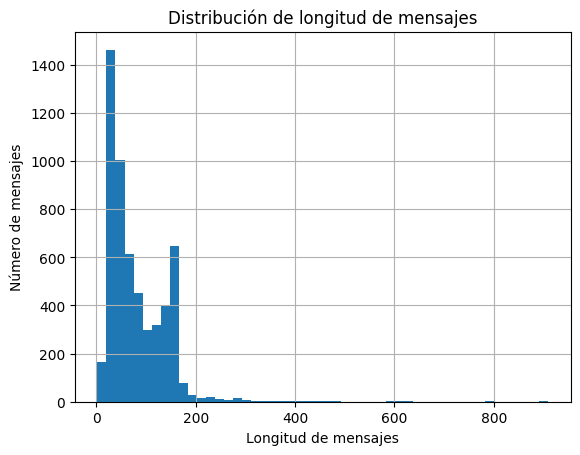

In [9]:

df['v2'].str.len().hist(bins=50)
plt.title('Distribución de longitud de mensajes')
y_label = plt.ylabel('Número de mensajes')
x_label = plt.xlabel('Longitud de mensajes')
plt.show()

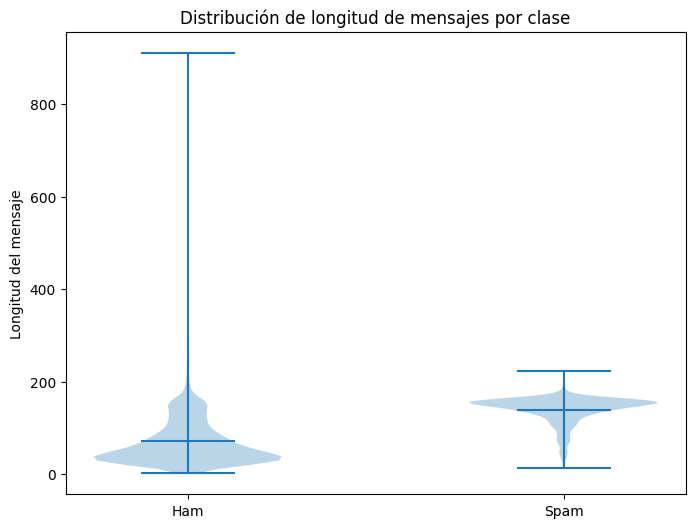

In [10]:
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[df[df['v1'] == 'ham']['v2'].str.len(), df[df['v1'] == 'spam']['v2'].str.len()],
               showmeans=True)
plt.xticks([1, 2], ['Ham', 'Spam'])
plt.title('Distribución de longitud de mensajes por clase')
plt.ylabel('Longitud del mensaje')
plt.show()

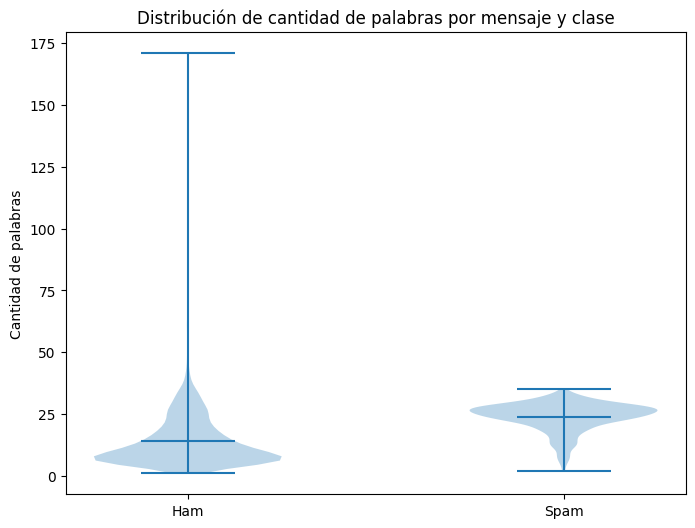

In [11]:
# distribuicion de palabras de ham y spam 
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[df[df['v1'] == 'ham']['v2'].str.split().apply(len), df[df['v1'] == 'spam']['v2'].str.split().apply(len)],
               showmeans=True)
plt.xticks([1, 2], ['Ham', 'Spam'])
plt.title('Distribución de cantidad de palabras por mensaje y clase')
plt.ylabel('Cantidad de palabras')

plt.show()


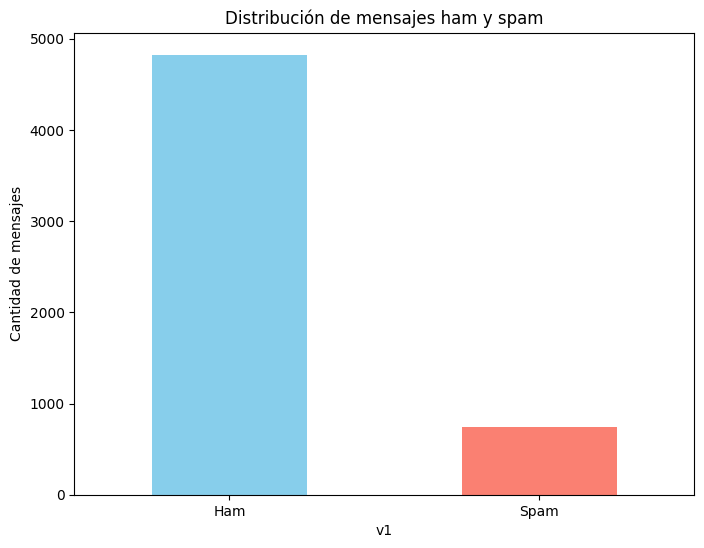

In [12]:
#cantidad de ham y spam 

plt.figure(figsize=(8, 6))

df['v1'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de mensajes ham y spam')
plt.ylabel('Cantidad de mensajes')
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)

plt.show()


# LIMPIEZA DE DATOS 

In [13]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jsken\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
import re

def clean_text(text):
    # Remover caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenizar el texto
    tokens = nltk.word_tokenize(text)
    
    # Remover stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lematización
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    
    return tokens

In [16]:
df['v2_cleaned'] = df['v2'].apply(clean_text)

#crear nuevo dataframe con las palabras limpias y su tipo de mensaje
df_cleaned = df[['v1', 'v2_cleaned']].copy()

#cambia el nombre de las columnas  para que sea más entendible
df_cleaned.columns = ['label', 'message']

df_cleaned.head()

,label,message
0,ham,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,"[ok, lar, joke, wif, u, oni]"
2,spam,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"[nah, dont, think, go, usf, life, around, though]"


# MODELO

## probabilidad de que una palabra sea SPAM

In [17]:
# Contar el número total de mensajes spam y ham
spam_count = df_cleaned[df_cleaned['label'] == 'spam'].shape[0]
ham_count = df_cleaned[df_cleaned['label'] == 'ham'].shape[0]
total_count = spam_count + ham_count

# Calcular P(S) y P(H)
P_spam = spam_count / total_count
P_ham = ham_count / total_count

# Función para calcular P(W|S) y P(W|H)
def calc_word_prob(word, spam_messages, ham_messages):
    spam_word_count = spam_messages[spam_messages['message'].apply(lambda x: word in x)].shape[0]
    ham_word_count = ham_messages[ham_messages['message'].apply(lambda x: word in x)].shape[0]
    
    P_word_spam = (spam_word_count + 1) / (spam_count + 2)  # Suavizado de Laplace
    P_word_ham = (ham_word_count + 1) / (ham_count + 2)  # Suavizado de Laplace
    
    return P_word_spam, P_word_ham

In [18]:
# Función para calcular P(W|S) y P(W|H)
def calc_spam_probability(word):
    P_word_spam, P_word_ham = calc_word_prob(word, df_cleaned[df_cleaned['label'] == 'spam'], df_cleaned[df_cleaned['label'] == 'ham'])
    
    P_spam_given_word = (P_word_spam * P_spam) / (P_word_spam * P_spam + P_word_ham * P_ham)
    
    return P_spam_given_word

In [26]:
#calcular la probabilidad de que una palabra sea spam 
word = 'free'

P_spam_given_word = calc_spam_probability(word)

print(f'La probabilidad de que el mensaje sea spam dado que contiene la palabra "{word}" es: {P_spam_given_word:.4f}')


La probabilidad de que el mensaje sea spam dado que contiene la palabra "free" es: 0.7419


## probabilidad de que un texto sea SPAM dado que contiene un conjunto de palabras utilizando la fórmula proporcionada

In [20]:
from functools import reduce

def calc_spam_probability_text(text):
    words = clean_text(text)
    P_spam_given_words = [calc_spam_probability(word) for word in words]
    
    P_spam_given_text = reduce(lambda x, y: x * y, P_spam_given_words) / (reduce(lambda x, y: x * y, P_spam_given_words) + reduce(lambda x, y: x * y, [1 - prob for prob in P_spam_given_words]))
    
    return P_spam_given_text



In [25]:

text = 'claim money'
P_spam_given_text = calc_spam_probability_text(text)

print(f'La probabilidad de que el mensaje sea spam dado el texto "{text}" es: {P_spam_given_text:.4f}')

La probabilidad de que el mensaje sea spam dado el texto "claim money" es: 0.8939


# PRUEBAS DE RENDIMIENTO

In [27]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X = df['v2']
y = df['v1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.DataFrame({'label': y_train, 'message': X_train})
df_test = pd.DataFrame({'label': y_test, 'message': X_test})

df_train['message'] = df_train['message'].apply(clean_text)
df_test['message'] = df_test['message'].apply(clean_text)


In [28]:
df_test

,label,message
3245,ham,"[funni, fact, nobodi, teach, volcano, erupt, t..."
944,ham,"[sent, score, sopha, secondari, applic, school..."
1044,spam,"[know, someon, know, fanci, call, find, pobox,..."
2484,ham,"[promis, get, soon, youll, text, morn, let, kn..."
812,spam,"[congratul, ur, award, either, cd, gift, vouch..."
...,...,...
4264,ham,"[ltdecimalgt, common, car, better, buy, china,..."
2439,ham,"[rightio, well, arent, bright, earli, morn]"
5556,ham,"[ye, that, u, text, pshewmiss, much]"
4205,ham,"[get, door, im]"


In [29]:
def calc_spam_probability_text_predict(text):
    words = clean_text(text)
    
    if not words:
        # Manejar el caso de una lista vacía
        return 0.5  # O cualquier otra probabilidad predeterminada
    
    P_spam_given_words = [calc_spam_probability_predict(word) for word in words]
    
    P_spam_given_text = reduce(lambda x, y: x * y, P_spam_given_words) / (
        reduce(lambda x, y: x * y, P_spam_given_words) +
        reduce(lambda x, y: x * y, [1 - prob for prob in P_spam_given_words])
    )
    
    return P_spam_given_text

def calc_spam_probability_predict(word):
    P_word_spam, P_word_ham = calc_word_prob(word, df_test[df_test['label'] == 'spam'], df_test[df_test['label'] == 'ham'])
    
    P_spam_given_word = (P_word_spam * P_spam) / (P_word_spam * P_spam + P_word_ham * P_ham)
    
    return P_spam_given_word

In [30]:
def predict_spam_probability_text(text):
    P_spam_given_text = calc_spam_probability_text_predict(text)
    
    return 'spam' if P_spam_given_text > 0.5 else 'ham'

df_test['predicted'] = df_test['message'].apply(lambda x: predict_spam_probability_text(' '.join(x)))


In [31]:
df_test

,label,message,predicted
3245,ham,"[funni, fact, nobodi, teach, volcano, erupt, t...",ham
944,ham,"[sent, score, sopha, secondari, applic, school...",ham
1044,spam,"[know, someon, know, fanci, call, find, pobox,...",ham
2484,ham,"[promis, get, soon, youll, text, morn, let, kn...",ham
812,spam,"[congratul, ur, award, either, cd, gift, vouch...",spam
...,...,...,...
4264,ham,"[ltdecimalgt, common, car, better, buy, china,...",ham
2439,ham,"[rightio, well, arent, bright, earli, morn]",ham
5556,ham,"[ye, that, u, text, pshewmiss, much]",ham
4205,ham,"[get, door, im]",ham


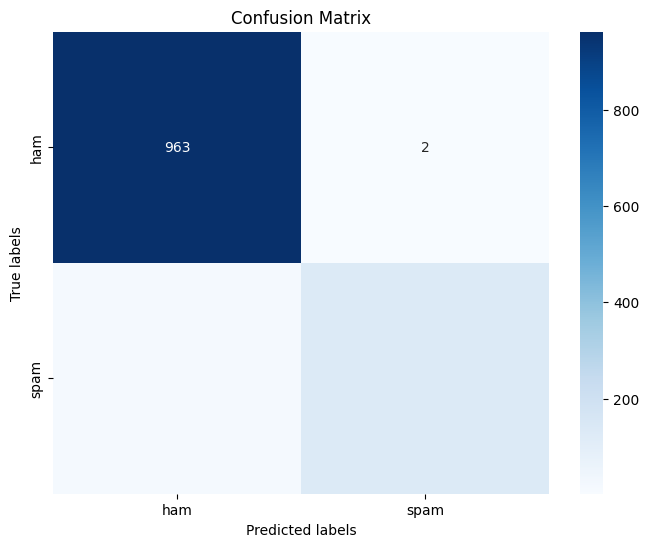

In [32]:
conf_matrix = confusion_matrix(df_test['label'], df_test['predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [33]:
#nivel de precisión, recall y f1-score

print(classification_report(df_test['label'], df_test['predicted']))


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.99      0.88      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

